## Bayesian Model (global vocab prob $\beta_m$)

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = sio.loadmat('kos_doc_data.mat')

A = data['A']
B = data['B']
V = data['V']

M = np.max([np.max(A[:, 1]), np.max(B[:, 1])])   # total no of vocabs
M

6906

In [3]:
A.shape[0] + B.shape[0]

353160

### Calculate log probability for the test document with ID 2001.

In [66]:
d = 2001

test_document = np.where(B[:, 0] == d)  # get all occurrences of document d in the training data
w = B[test_document, 1][0]  # IDs of vocabs **in document d**
c = B[test_document, 2][0]  # counts of those vocabs **in document d**, c_m,d

print('vocab IDs, w =', w, '\n')
print('vocab counts, c =', c, '\n')

print('Check if `w` and `c` have the same length:', w.shape == c.shape, '\n')

print('There are', w.shape[0], 'vocabs in doc', d, ';', sum(c), 'words in total', '\n')

BI_beta = np.load('results/b/BI_beta_IDorder.npy')    # gamma = 1
print('BI_beta =', BI_beta)

vocab IDs, w = [  69   75   76   77   89  149  264  281  306  337  352  434  478  518
  520  549  580  585  707  720  747  756  841  847  849  850  910  912
 1000 1035 1078 1084 1114 1120 1168 1197 1231 1259 1274 1331 1334 1336
 1400 1416 1477 1516 1518 1531 1553 1597 1601 1614 1656 1663 1740 1756
 1775 1837 1838 1873 1959 1978 1992 1996 1999 2000 2030 2031 2032 2042
 2072 2073 2074 2128 2220 2232 2278 2279 2353 2356 2369 2375 2409 2410
 2429 2533 2641 2654 2706 2756 2764 2876 2877 2919 2920 2937 2953 2959
 3107 3120 3123 3129 3130 3131 3156 3157 3170 3211 3226 3238 3245 3344
 3345 3346 3401 3424 3472 3530 3584 3585 3655 3656 3693 3695 3700 3754
 3760 3771 3772 3776 3789 3791 3936 3950 3970 3980 4092 4155 4185 4186
 4190 4194 4268 4319 4467 4497 4505 4509 4511 4519 4543 4565 4592 4734
 4743 4757 4799 4800 4811 4917 4973 4991 5036 5039 5040 5051 5057 5066
 5098 5120 5121 5132 5136 5138 5157 5168 5173 5185 5186 5202 5307 5365
 5435 5451 5529 5626 5641 5678 5680 5681 5712 5718 5725 5735 5

In [67]:
log_prob_sequence_d = 0

for i, m in enumerate(w):    # iterate over all vocab IDs in doc d.
    
    log_prob_sequence_d += c[i] * np.log(BI_beta[m-1])    
    # `m-1` because `m` being the vocab IDs start from 1, but python indexing starts from 0.
    # `c[i]` is the vocab count c_m corresponding to the current beta_m
    
log_prob_sequence_d

-3688.6211698172983

### Calculate per-word perplexity for doc 2001

In [69]:
N_d = sum(c)    # total no of words in doc d.

PWPP_d = np.exp(- 1/N_d * log_prob_sequence_d)
PWPP_d

4373.110988104829

### Calculate per-word perplexity over all documents in B

*Be careful about re-running the codes above after running the code below, cuz variables with the same names are defined below.*

In [93]:
test_docs = np.unique(B[:,0])
# print(test_docs)

log_prob_test_set = 0
log_prob_docs = []
word_count_docs = []

for d in test_docs:
    
    # Retrive info from doc d as before.
    test_document = np.where(B[:, 0] == d)
    w = B[test_document, 1][0]    # vocab IDs in doc d
    c = B[test_document, 2][0]    # vocab counts in doc d
    
    # Calculate log prob for doc d as before.
    log_prob_sequence_d = 0
    for i, m in enumerate(w):    # iterate over all vocab IDs in doc d.
        log_prob_sequence_d += c[i] * np.log(BI_beta[m-1]) 
    
    log_prob_test_set += log_prob_sequence_d
    
    log_prob_docs.append(log_prob_sequence_d)
    word_count_docs.append(sum(c))

N_test_set = np.sum(B[:,2])
PWPP_test_set = np.exp(- 1/N_test_set * log_prob_test_set)
print('PWPP_test_set =', PWPP_test_set)


# Sanity Check: `N_test_set` is indeed the total word counts across all test docs.   [Test passed]
# print(sum(word_count_docs) == N_test_set)

PWPP_test_set = 2683.9840703508507


### Demonstrate different test docs have different perplexities `PWPP_d` given the trained $\beta_m$.

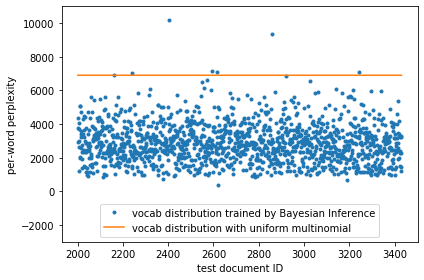

In [128]:
# Sanity Check: the lists of log prob and total word counts of the test doc match each other.
# len(log_prob_docs) == len(word_count_docs)

PWPP_docs = []

for i, log_prob_d in enumerate(log_prob_docs):
    PWPP_d = np.exp(- 1/word_count_docs[i] * log_prob_d)  # PWPP for a single doc.
    PWPP_docs.append(PWPP_d)

# print(PWPP_docs)  # Note that the first element matches the PWPP_d for doc 2001, which equals 4373.1.

# plt.figure(figsize=(8,2))
# plt.plot(test_docs, log_prob_docs, '.', label='log probability of word sequence of each doc')
plt.plot(test_docs, PWPP_docs, '.', label='vocab distribution trained by Bayesian Inference')

plt.plot(test_docs, [M]*test_docs.shape[0], label='vocab distribution with uniform multinomial')

# plt.plot(test_docs, [0]*test_docs.shape[0], 'k')

plt.ylim([-3000,11000])
plt.legend(loc='lower center')

plt.xlabel('test document ID')
plt.ylabel('per-word perplexity')

plt.tight_layout()
plt.savefig('results/c/PWPP_test.png')

Per-word perplexity (PWPP) of a document basically means the number of "available choices" for choosing an observed word from all the vocabs. "Available choices" refers to the average number of choices **weighted by the vocab probabilities** $\underline{\beta}$.

For example, if vocab distribution is a uniform multinomial, i.e. all vocabs have the same probability of being chosen ($\beta_m = \frac{1}{M}$), then for choosing an observed word, you can choose from $M = 6906$ "available choices". The PPWP is $M$, as shown in ***Figure 3***.

On the other hand, when the vocab distribution is trained by Bayesian Inference, some vocabs will have higher probabilities $\beta_m$ than others because they were previously observed more frequently in the training documents. This extra information lowers the uncertainty for choosing an observed word in a test document, hence the number of "available choices" (PWPP) decreases, as shown in most datapoints in ***Figure 3***. As a side note, different documents have different PWPPs because their different sets of words $\underline{w}_d$ yield different joint probabilities $p(\underline{w}_d)$ from $\underline{\beta}$.

Finally, an explanation for **why some test documents have PWPP (for Bayesian model) greater than $M = 6906$** is given here. Although **non-uniform** vocab multinomial distribution generally lowers PWPP, this only works when most words in the particular test document are also frequently observed in the training documents. Otherwise the joint probabilities of words in the test document will be smaller than $(\frac{1}{M})^{N_d}$, just like the words with tiny $\beta_m$ in ***Figure 2***. As a result, PWPPs for those documents are greater than $M$.